In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from skopt.space import Categorical
from sklearn.model_selection import train_test_split
import pandas as pd


In [31]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [32]:
# Tworzenie pipeline z preprocesorem
def create_pipeline_with_preprocessing(model):
    si_cat = SimpleImputer(strategy="constant", fill_value="NO INFORMATION")
    si_num = SimpleImputer(strategy="median")
    scaler = MinMaxScaler()

    category_pipeline = Pipeline(steps=[
        ('imputer', si_cat),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    numerical_pipeline = Pipeline(steps=[
        ('imputer', si_num),
        ('scaler', scaler)
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_pipeline, make_column_selector(dtype_include=np.number)),
            ("cat", category_pipeline, make_column_selector(dtype_include='object'))
        ]
    )

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    return pipeline

# Funkcja do optymalizacji BayesSearchCV
def get_bayes_param_score_list(X_train, y_train, X_test, y_test, estimator, param_distributions, n_iter):
    score_list = []
    param_list = []
    iteration_vector = range(10, n_iter + 10, 10)

    for i in iteration_vector:
        bayes_search = BayesSearchCV(
            estimator=estimator,
            search_spaces=param_distributions,
            n_iter=i,
            cv=5,
            scoring='r2',
            random_state=42,
            verbose=1 
        )
        bayes_search.fit(X_train, y_train)
        score_list.append(bayes_search.score(X_test, y_test))
        param_list.append(bayes_search.best_params_)

    return iteration_vector, param_list, score_list

# Tworzenie wykresu
def r2_iteration_plot(iteration_vector, values, model_name, dataset_name):
    print(f"Running model: {model_name} on dataset: {dataset_name}")
    plt.figure(figsize=(10, 6))
    plt.plot(iteration_vector, values, marker='o', linestyle='-', color='b', label='R^2')
    plt.ylim(0, 1)
    plt.title(f"Wartość R^2 w zależności od liczby iteracji ({model_name} - {dataset_name})")
    plt.xlabel('Iteracje')
    plt.ylabel('R^2')
    plt.grid(True)
    plt.legend()
    plt.show()

# Zapis najlepszych wyników do pliku
def save_best_results(dataset_name, model_name, param_list, score_list):
    best_idx = np.argmax(score_list)
    best_score = score_list[best_idx]
    best_params = param_list[best_idx]
    print(f"Best score for {model_name} on {dataset_name}: {best_score} with params: {best_params}")

    # Zapis wyników do CSV
    results_df = pd.DataFrame({'Iteracja': [10 * (i + 1) for i in range(len(score_list))],
                               'R2': score_list,
                               'Params': param_list})
    results_df.to_csv(f"{dataset_name}_{model_name}_results.csv", index=False)

# Główna funkcja przetwarzania modelu
def process_model(dataset_name, X_train, y_train, X_test, y_test, model_name, model, param_distributions, n_iter=100):
    """
    
    """
    print(f"Processing {model_name} for {dataset_name}...")
    pipeline = create_pipeline_with_preprocessing(model)
    
    try:
        iterations, param_list, score_list = get_bayes_param_score_list(
            X_train, y_train, X_test, y_test, pipeline, param_distributions, n_iter
        )
        r2_iteration_plot(iterations, score_list, model_name, dataset_name)
        save_best_results(dataset_name, model_name, param_list, score_list)
    except Exception as e:
        print(f"Error processing {model_name} for {dataset_name}: {e}")

In [33]:
# Wczytanie danych
df_Flight_price = pd.read_csv("../data/Flight_price.csv")[:10000]
df_Salary = pd.read_csv("../data/salary_prediction_data.csv")
df_phone = pd.read_csv("../data/Cellphone.csv")
df_Diamonds = pd.read_csv("../data/Diamonds_Price.csv")

# Przygotowanie danych - Diamonds Dataset
X_diamonds = df_Diamonds.drop(columns=["price"], axis=1)
Y_diamonds = df_Diamonds['price']
X_diamonds_train, X_diamonds_test, y_diamonds_train, y_diamonds_test = train_test_split(X_diamonds, Y_diamonds, test_size=0.3, random_state=42)

# Przygotowanie danych - Phone Dataset
X_phone = df_phone.drop(columns=["Price", "Product_id"], axis=1)
Y_phone = df_phone['Price']
X_phone_train, X_phone_test, y_phone_train, y_phone_test = train_test_split(X_phone, Y_phone, test_size=0.3, random_state=42)

# Przygotowanie danych - Flight Dataset
X_flight = df_Flight_price.drop(columns=["Unnamed: 0", "flight", "price"], axis=1)
Y_flight = df_Flight_price['price']
X_flight_train, X_flight_test, y_flight_train, y_flight_test = train_test_split(X_flight, Y_flight, test_size=0.3, random_state=42)

# Przygotowanie danych - Salary Dataset
X_salary = df_Salary.drop(columns=["Salary"], axis=1)
Y_salary = df_Salary['Salary']
X_salary_train, X_salary_test, y_salary_train, y_salary_test = train_test_split(X_salary, Y_salary, test_size=0.3, random_state=42)




In [34]:
# Parametry dla Random Forest
param_distribution_rf = {
    'model__n_estimators': (1, 500),  
    'model__min_samples_split': (2, 10),  
    'model__min_samples_leaf': (2, 10)  
}

# Parametry dla ElasticNet
param_distributions_enet = {
    'model__alpha': (1e-4, 1),  
    'model__l1_ratio': (0, 1)  
}

# Parametry dla XGBoost
param_distributions_xgb = {
    'model__min_child_weight': (1, 128), 
    'model__max_depth': Categorical([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]),
    'model__colsample_bytree': (0, 1)  
}


Processing RandomForest for Diamonds...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds 

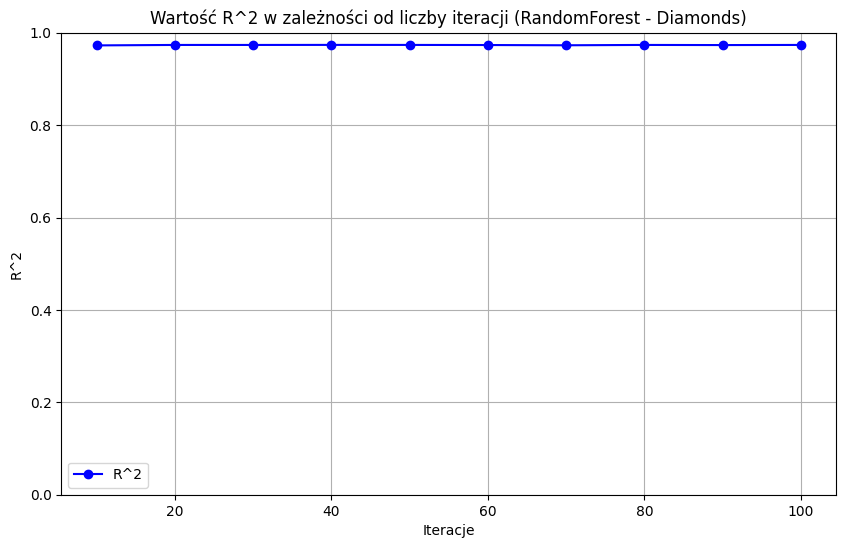

Best score for RandomForest on Diamonds: 0.9736480044081885 with params: OrderedDict({'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 309})


In [35]:
# Random Forest
process_model(
    dataset_name="Diamonds",
    X_train=X_diamonds_train, y_train=y_diamonds_train,
    X_test=X_diamonds_test, y_test=y_diamonds_test,
    model_name="RandomForest",
    model=RandomForestRegressor(),
    param_distributions=param_distribution_rf,
    n_iter=100
)



Processing ElasticNet for Diamonds...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds fo

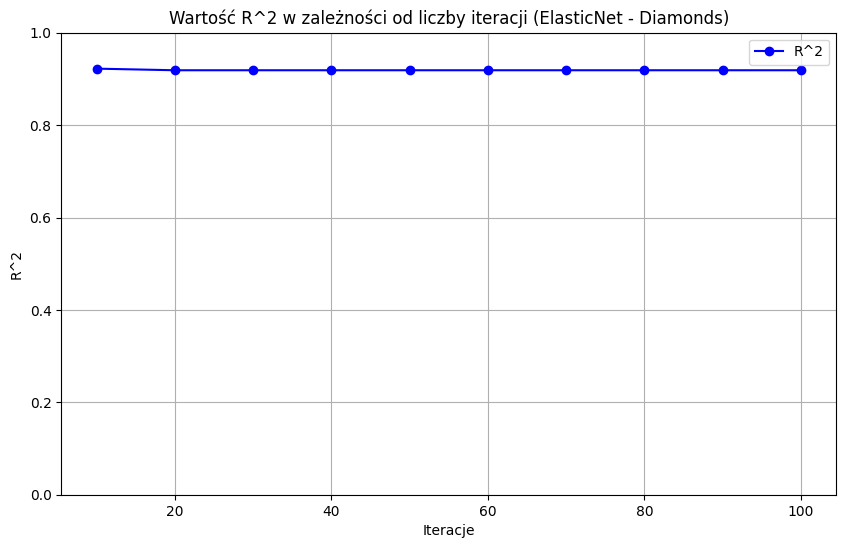

Best score for ElasticNet on Diamonds: 0.9222434931769741 with params: OrderedDict({'model__alpha': 0.9554824385112973, 'model__l1_ratio': 1})


In [36]:
# ElasticNet
process_model(
    dataset_name="Diamonds",
    X_train=X_diamonds_train, y_train=y_diamonds_train,
    X_test=X_diamonds_test, y_test=y_diamonds_test,
    model_name="ElasticNet",
    model=ElasticNet(),
    param_distributions=param_distributions_enet,
    n_iter=100
)

Processing XGBoost for Diamonds...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for e

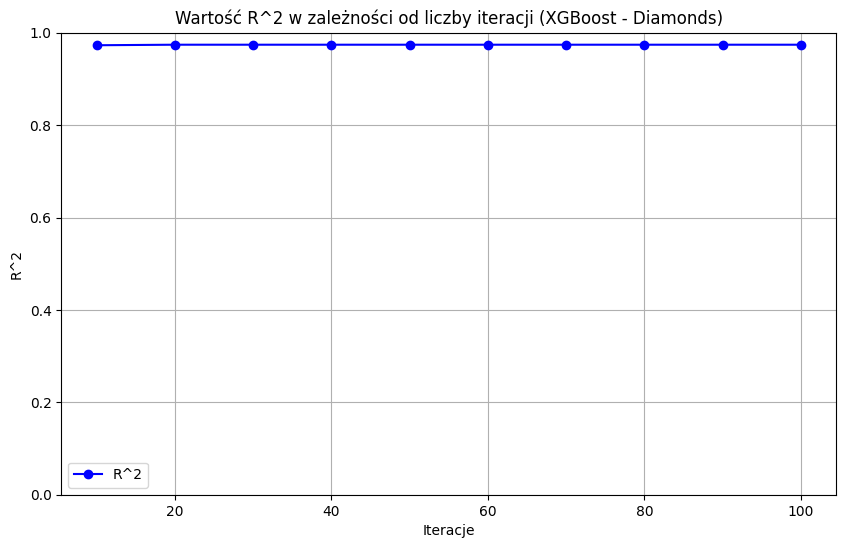

Best score for XGBoost on Diamonds: 0.9740539789199829 with params: OrderedDict({'model__colsample_bytree': 1, 'model__max_depth': 4, 'model__min_child_weight': 1})


In [37]:
# XGBoost
process_model(
    dataset_name="Diamonds",
    X_train=X_diamonds_train, y_train=y_diamonds_train,
    X_test=X_diamonds_test, y_test=y_diamonds_test,
    model_name="XGBoost",
    model=XGBRegressor(),
    param_distributions=param_distributions_xgb,
    n_iter=100
)

Processing RandomForest for Flight...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds fo

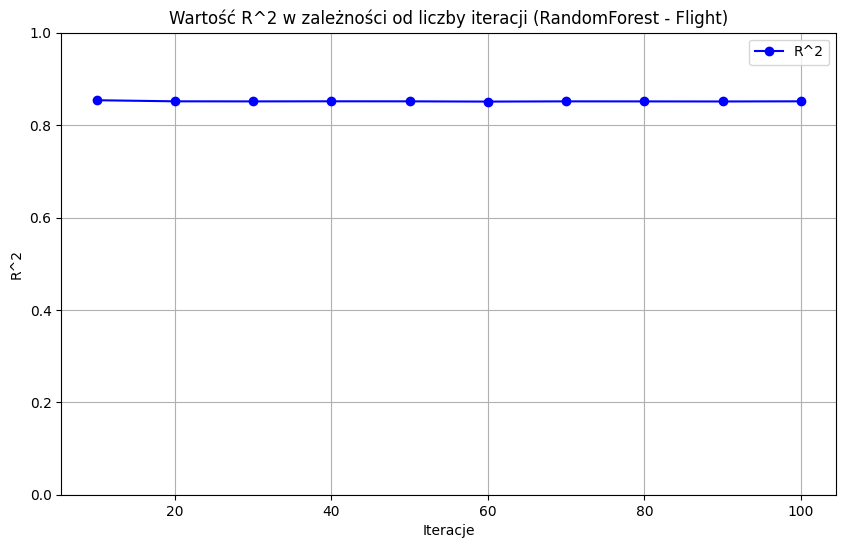

Best score for RandomForest on Flight: 0.8538746548016237 with params: OrderedDict({'model__min_samples_leaf': 2, 'model__min_samples_split': 9, 'model__n_estimators': 371})


In [38]:
# Random Forest
process_model(
    dataset_name="Flight",
    X_train=X_flight_train, y_train=y_flight_train,
    X_test=X_flight_test, y_test=y_flight_test,
    model_name="RandomForest",
    model=RandomForestRegressor(),
    param_distributions=param_distribution_rf,
    n_iter=100
)



Processing ElasticNet for Flight...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for 

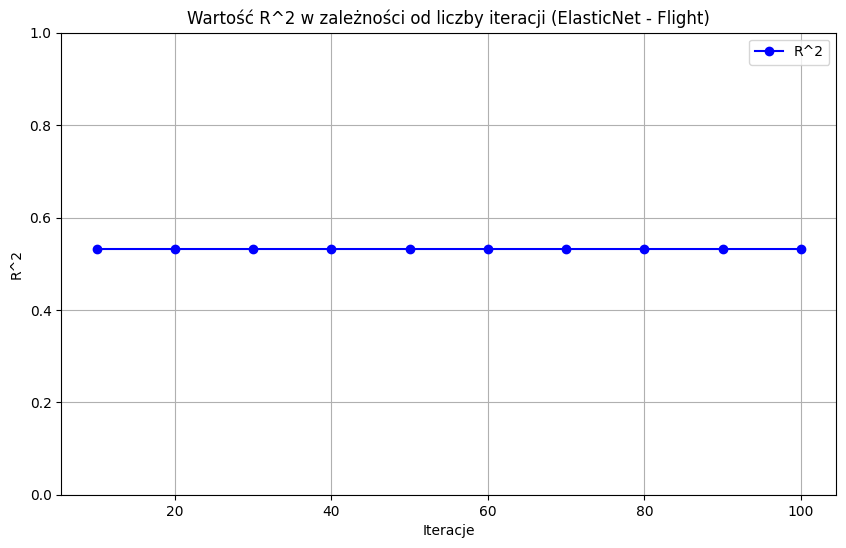

Best score for ElasticNet on Flight: 0.5318418550490214 with params: OrderedDict({'model__alpha': 0.9554824385112973, 'model__l1_ratio': 1})


In [39]:
# ElasticNet
process_model(
    dataset_name="Flight",
    X_train=X_flight_train, y_train=y_flight_train,
    X_test=X_flight_test, y_test=y_flight_test,
    model_name="ElasticNet",
    model=ElasticNet(),
    param_distributions=param_distributions_enet,
    n_iter=100
)

Processing XGBoost for Flight...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for eac

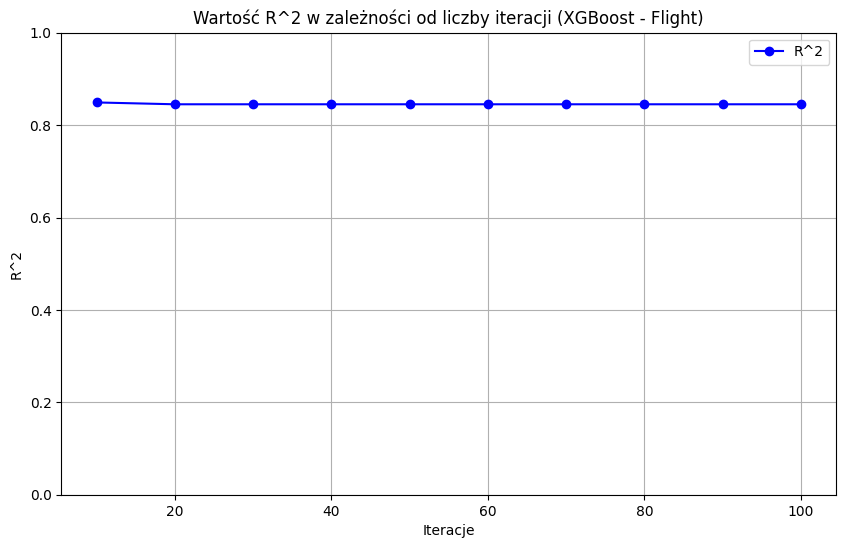

Best score for XGBoost on Flight: 0.849086582660675 with params: OrderedDict({'model__colsample_bytree': 1, 'model__max_depth': 15, 'model__min_child_weight': 22})


In [40]:
# XGBoost
process_model(
    dataset_name="Flight",
    X_train=X_flight_train, y_train=y_flight_train,
    X_test=X_flight_test, y_test=y_flight_test,
    model_name="XGBoost",
    model=XGBRegressor(),
    param_distributions=param_distributions_xgb,
    n_iter=100
)

Processing RandomForest for Salary...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds fo

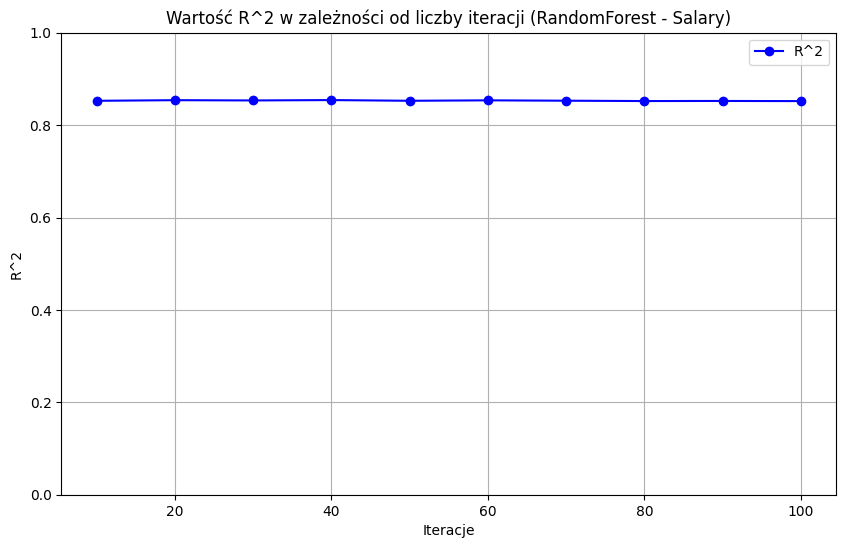

Best score for RandomForest on Salary: 0.8542200416700781 with params: OrderedDict({'model__min_samples_leaf': 3, 'model__min_samples_split': 9, 'model__n_estimators': 500})


In [41]:
# Random Forest
process_model(
    dataset_name="Salary",
    X_train=X_salary_train, y_train=y_salary_train,
    X_test=X_salary_test, y_test=y_salary_test,
    model_name="RandomForest",
    model=RandomForestRegressor(),
    param_distributions=param_distribution_rf,
    n_iter=100
)

Processing ElasticNet for Salary...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for 

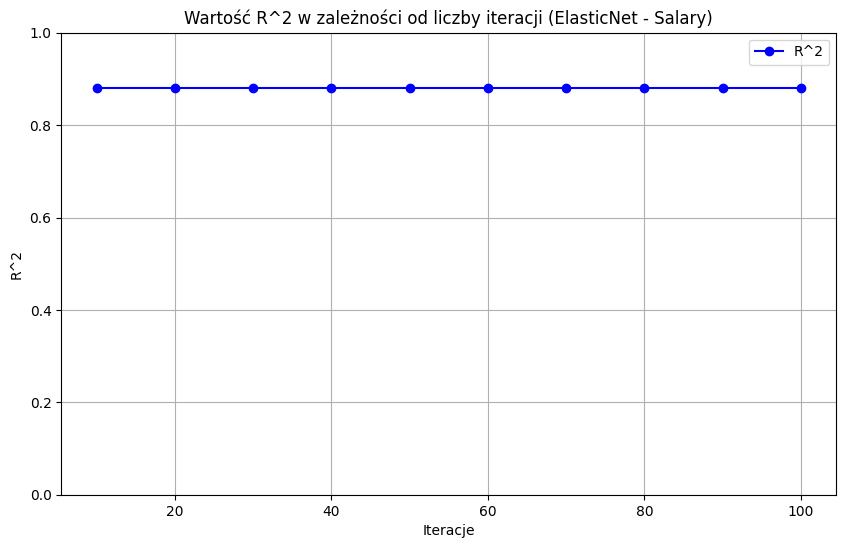

Best score for ElasticNet on Salary: 0.8803722814617871 with params: OrderedDict({'model__alpha': 0.837404616717729, 'model__l1_ratio': 1})


In [42]:
# ElasticNet
process_model(
    dataset_name="Salary",
    X_train=X_salary_train, y_train=y_salary_train,
    X_test=X_salary_test, y_test=y_salary_test,
    model_name="ElasticNet",
    model=ElasticNet(),
    param_distributions=param_distributions_enet,
    n_iter=100
)

Processing XGBoost for Salary...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for eac

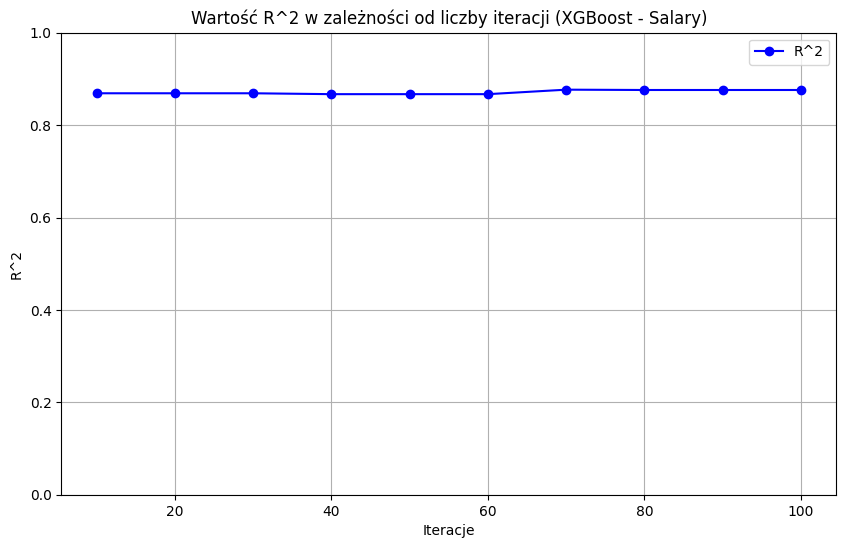

Best score for XGBoost on Salary: 0.8767397795016255 with params: OrderedDict({'model__colsample_bytree': 1, 'model__max_depth': 1, 'model__min_child_weight': 121})


In [43]:
# XGBoost
process_model(
    dataset_name="Salary",
    X_train=X_salary_train, y_train=y_salary_train,
    X_test=X_salary_test, y_test=y_salary_test,
    model_name="XGBoost",
    model=XGBRegressor(),
    param_distributions=param_distributions_xgb,
    n_iter=100
)

Processing RandomForest for Phone...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for

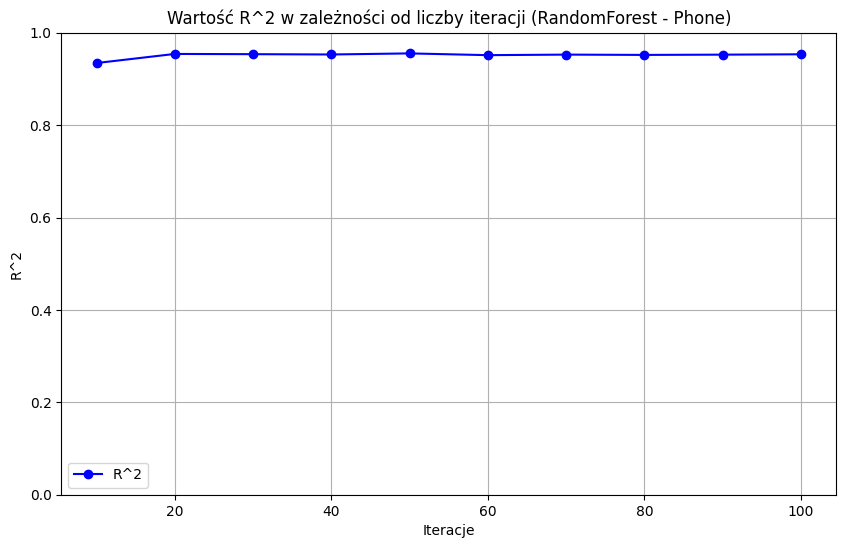

Best score for RandomForest on Phone: 0.9552321664596665 with params: OrderedDict({'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 500})


In [44]:
# Random Forest
process_model(
    dataset_name="Phone",
    X_train=X_phone_train, y_train=y_phone_train,
    X_test=X_phone_test, y_test=y_phone_test,
    model_name="RandomForest",
    model=RandomForestRegressor(),
    param_distributions=param_distribution_rf,
    n_iter=100
)

Processing ElasticNet for Phone...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for e

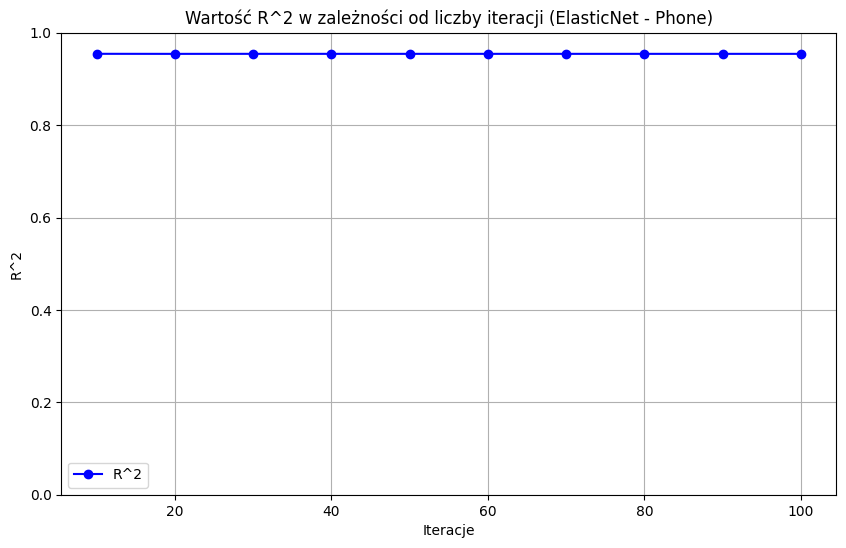

Best score for ElasticNet on Phone: 0.954359781129754 with params: OrderedDict({'model__alpha': 0.4101629484574285, 'model__l1_ratio': 1})


In [45]:
# ElasticNet
process_model(
    dataset_name="Phone",
    X_train=X_phone_train, y_train=y_phone_train,
    X_test=X_phone_test, y_test=y_phone_test,
    model_name="ElasticNet",
    model=ElasticNet(),
    param_distributions=param_distributions_enet,
    n_iter=100
)

Processing XGBoost for Phone...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each

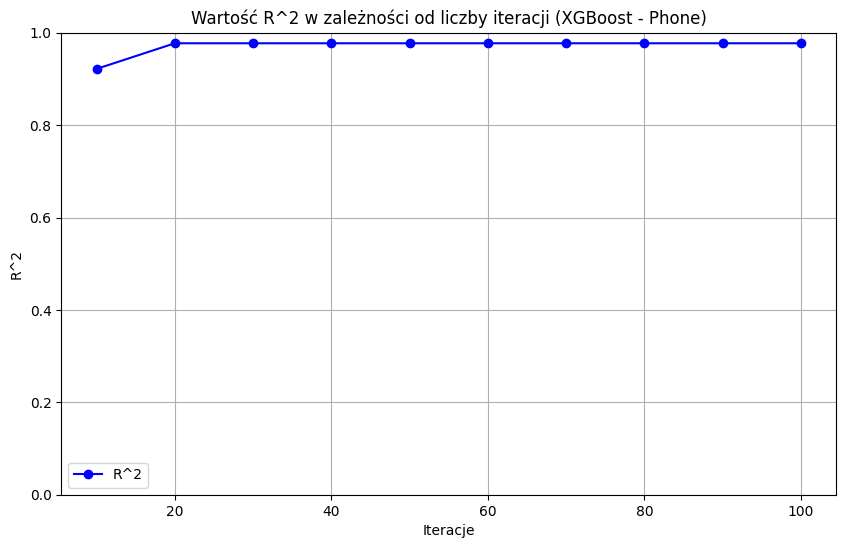

Best score for XGBoost on Phone: 0.9771600365638733 with params: OrderedDict({'model__colsample_bytree': 1, 'model__max_depth': 7, 'model__min_child_weight': 3})


In [46]:
# XGBoost
process_model(
    dataset_name="Phone",
    X_train=X_phone_train, y_train=y_phone_train,
    X_test=X_phone_test, y_test=y_phone_test,
    model_name="XGBoost",
    model=XGBRegressor(),
    param_distributions=param_distributions_xgb,
    n_iter=100
)